#### CVEN 6525 - NONLINEAR ANALYSIS OF FRAMED STRUCTURES
##### FINAL TERM PROJECT - SPRING 2024 - RON BAILIE, UNIVERSITY OF COLORADO BOULDER

<center> Topology Optimization of 2D structural elements using the SIMP method</center><br>  
The following is a python implementation of Ole Sigmund's <i>a 99 line topology optimization code written in MATLAB</i>......


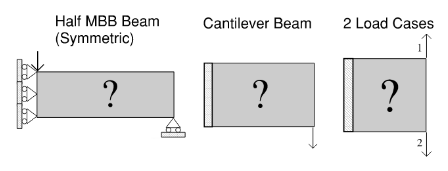

In [109]:
#IPython magic commands
%matplotlib notebook
%matplotlib inline

#package imports
import numpy as np
import base64
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib import colors as mcolors
from IPython.display import HTML

np.set_printoptions(precision=4) # limit floating point values to 4 decimal places

#embedding images into Jupyter notebook/encoded into base64
with open("/home/ron/thesis/topopt_simulation_cm2/topOpt benchmark analysis.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
benchmark_images = f'<img src="data:image/png;base64,{encoded_string}"/>'
display(HTML(benchmark_images))

#### FEM EXPLANATION

In [110]:
def FE(nelx, nely, x, penal, lk):
    KE = lk()  # Global stiffness matrix
    K = np.zeros(((nelx + 1) * (nely + 1) * 2, (nelx + 1) * (nely + 1) * 2))
    F = np.zeros(((nelx + 1) * (nely + 1) * 2, 1))
    U = np.zeros(((nelx + 1) * (nely + 1) * 2, 1))

    # assemble global stiffness matrix
    for elx in range(1, nelx + 1): 
        for ely in range(1, nely + 1):
            n1 = (nely + 1) * (elx - 1) + ely  # upper right element node number for Ue
            n2 = (nely + 1) * elx + ely  # extract element disp from global disp
            edof = np.array(
                [
                    2 * n1 - 1,
                    2 * n1,
                    2 * n2 - 1,
                    2 * n2,
                    2 * n2 + 1,
                    2 * n2 + 2,
                    2 * n1 + 1,
                    2 * n1 + 2,
                ]
            )
            K[np.ix_(edof - 1, edof - 1)] += x[ely - 1, elx - 1] ** penal * KE
    
    #load placed at middle of beam
    top_mid_node = (nelx//2) +1
    F[top_mid_node, 0] = -100
    
    #load placed at left side of beam
    # load_dof = 1
    # F[load_dof,0] = -1
    
    # loads and supports
    # identify geometrically constrained nodes from element x and y arrays
     
#     dof_fixed = np.union1d(
#     np.arange(0, 2 * (nely + 1), 2), np.array([2 * (nelx + 1) * (nely + 1) - 2 * nely -1])
# )

    dof_fixed = np.union1d(
        np.arange(0, 2 * (nely + 1), 2), np.array([2 * (nelx + 1) * (nely + 1) - 1])
    )

    # array of nodes from element x and y arrays
    dofs = np.arange(0, 2 * (nelx + 1) * (nely + 1))
    # filter mask to grab free nodes from node list
    dof_free = np.setdiff1d(dofs, dof_fixed)

    # # SOLVER
    U[dof_free] = np.linalg.solve(
        K[np.ix_(dof_free, dof_free)], F[dof_free]
    )  # solve for displacement at free nodes
    U[dof_fixed] = 0  # fix geometrically constrained nodes
    
    return U, dof_fixed, load_dof

#### ELEMENT STIFFNESS 2D EXPLANATION

In [111]:
def lk():
    E = 1.0
    nu = 0.3
    k = np.array(
        [
            1 / 2 - nu / 6,
            1 / 8 + nu / 8,
            -1 / 4 - nu / 12,
            -1 / 8 + 3 * nu / 8,
            -1 / 4 + nu / 12,
            -1 / 8 - nu / 8,
            nu / 6,
            1 / 8 - 3 * nu / 8,
        ]
    )

    KE = (
        E
        / (1 - nu**2)
        * np.array(
            [
                [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]],
            ]
        )
    )
    return KE  # after assembly

#### MESH INDEPENDENCY FILTER EXPLANATION

In [112]:
def check(nelx, nely, rmin, x, dc):
    dcn = np.zeros((nely, nelx))  # initialize
    rmin_floor = int(np.floor(rmin))

    for i in range(nelx):  # first element in dependency check
        for j in range(nely):  # second element in dependency check
            sum = 0.0
            for k in range(max(i - rmin_floor, 0), min(i + rmin_floor + 1, nelx)):
                for l in range(max(j - rmin_floor, 0), min(j + rmin_floor + 1, nely)):
                    fac = rmin - np.sqrt((i - k) ** 2 + (j - l) ** 2)  # weighting factor with rmin as filter size minus distance between two elements
                    if fac > 0:
                        sum += fac
                        dcn[j, i] += fac * x[l, k] * dc[l, k]
            if sum > 0:
                dcn[j, i] /= x[j, i] * sum
    return dcn

#### OPTIMALITY CRITERIA EXPLANATION

In [113]:
def OC(nelx: int, nely: int, x: np.array, volfrac: float, dc: np.array):
    l1 = 0  # lower bi-sectioning bound
    l2 = 1e5  # upper bi-sectioning bound
    move = 0.2  # sectioning increment
    
    while (l2 - l1) > 1e-4:
        lmid = 0.5 * (l2 + l1)  # middle bi-sectioning value
        xnew = np.maximum(0.001,np.maximum(x - move, np.minimum(1.0, np.minimum(x + move, x * np.sqrt(-dc / lmid)))),)
        if np.sum(xnew) - volfrac * nelx * nely > 0:
            l1 = lmid
        else:
            l2 = lmid
    return xnew

## animation EXPLANATION - CHANGE TO HOST INSIDE OF IPYNB

In [114]:
def make_animation(nelx, nely, x_hist):
    x_hist = x_hist[::2]
    fig, ax = plt.subplots()
    im = ax.imshow(-x_hist[0], cmap="gray", animated=True)

    def update_frame(frame):
        x = -x_hist[frame]
        im.set_array(x)
        return (im,)

    anim = animation.FuncAnimation(
        fig,
        update_frame,
        frames=len(x_hist),
        blit=True,
    )
    plt.close(fig)
    return anim

### CONVERGENCE PLOT (SHOW MULTIPLE?)


In [115]:
def convergencePlot(c_hist):
    # plot demonstrating convergence
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(c_hist) + 1), c_hist, marker="o", linestyle="-", color="b")
    plt.title("Objective Function Convergence")
    plt.xlabel("Iteration Number")
    plt.ylabel("Objective Function Value")
    plt.grid(True)
    plt.show()

#### MAIN TOPOLOGY OPTIMIZATION FUNCTION

In [116]:
def topOpt(nelx, nely, volfrac, penal, rmin, n_iter: int):
    # initialization
    x_hist = []  # Store x for animation
    c_hist = []  # Store c for convergence plot
    x = np.ones((nely, nelx)) * volfrac  # initialize matrix populated by volfrac,
    # initial material distribution to set element density
    loop = 0  # intialize iterations for optimization
    change = 1.0  # updates iter

    while (change > 0.01):  # continues as change > 0.01, at which point convergence is observed
        loop += 1  # iteration counter
        xold = np.copy(x)  # store current x

        if loop > n_iter:
            break

        # FE Analysis
        U, dof_fixed, load_dof = FE(nelx, nely, x, penal, lk)  # displacement vector U

        # Objective function and sensitivity analysis
        KE = lk()
        c = 0.0  # initialize objective function value (compliance) as zero float type
        dc = np.zeros((nely, nelx))  # initialize sensitivity of objection function to 0
        for ely in range(1, nely + 1):  # nested for loop over element y component
            for elx in range(1, nelx + 1):  # nested foor loop over element x component
                # upper left element node number for element displacement Ue
                n1 = (nely + 1) * (elx - 1) + ely
                # upper right element node number for element displacement Ue
                n2 = (nely + 1) * (elx) + ely
                Ue_indices = [
                    2 * n1 - 2,
                    2 * n1 - 1,
                    2 * n2 - 2,
                    2 * n2 - 1,
                    2 * n2,
                    2 * n2 + 1,
                    2 * n1,
                    2 * n1 + 1,]
                
                Ue = U[Ue_indices]  # Extract the displacement vector for the element
                f_int = np.dot(Ue.T, np.dot(KE, Ue)) #
                f_int = f_int.item() # Convert to scalar
                
                c += (x[ely - 1, elx - 1] ** penal * f_int)  # add elemental contribution to objective function
                dc[ely - 1, elx - 1] = (-penal * x[ely - 1, elx - 1] ** (penal - 1) * f_int)  # sensitivity calculation of objective function

        c_hist.append(c.item())
        
        dc = check(nelx, nely, rmin, x, dc)  # filter sensitivies with check function
        x = OC(nelx, nely, x, volfrac, dc)  # update design variable x based on OC function
        
        change = np.max(np.abs(x - xold))  # calclulate max value to check convergence
        
        print(f"Iteration: {loop}, Objective: {c.item():.4f}, Volume: {np.mean(x):.4f}, Change: {change:.4f}")

        x_hist.append(x.copy())
    return (nelx, nely, x_hist, c_hist, dof_fixed, load_dof)

#### DEFINE PARAMETERS AND RUN OPTIMIZATION

In [117]:
nelx = 89 # number elements in x axis
nely = 30 # number elements in y axis
volfrac = 0.5  # fractional volume to remain after optimization
penal = 3.0  # penalization factor for intermediate density values
rmin = 1.5  # prevents checkerboarding and mesh dependancies (filter size)

# Run optimization
nelx, nely, x_hist, c_hist, dof_fixed, load_dof = topOpt(nelx, nely, volfrac, penal, rmin, n_iter=400)

Iteration: 1, Objective: 9829772.9351, Volume: 0.5000, Change: 0.2000
Iteration: 2, Objective: 5672851.0975, Volume: 0.5000, Change: 0.2000
Iteration: 3, Objective: 4029794.9726, Volume: 0.5000, Change: 0.2000
Iteration: 4, Objective: 3355745.5810, Volume: 0.5000, Change: 0.2000
Iteration: 5, Objective: 3147105.2865, Volume: 0.5000, Change: 0.2000
Iteration: 6, Objective: 3004489.9501, Volume: 0.5000, Change: 0.2000
Iteration: 7, Objective: 2901296.1371, Volume: 0.5000, Change: 0.2000
Iteration: 8, Objective: 2817391.4634, Volume: 0.5000, Change: 0.1686
Iteration: 9, Objective: 2755890.5009, Volume: 0.5000, Change: 0.1533
Iteration: 10, Objective: 2694543.9112, Volume: 0.5000, Change: 0.1847
Iteration: 11, Objective: 2620235.9434, Volume: 0.5000, Change: 0.2000
Iteration: 12, Objective: 2537823.4801, Volume: 0.5000, Change: 0.2000
Iteration: 13, Objective: 2469875.2151, Volume: 0.5000, Change: 0.1993
Iteration: 14, Objective: 2410996.6872, Volume: 0.5000, Change: 0.1821
Iteration: 15, 

[1]


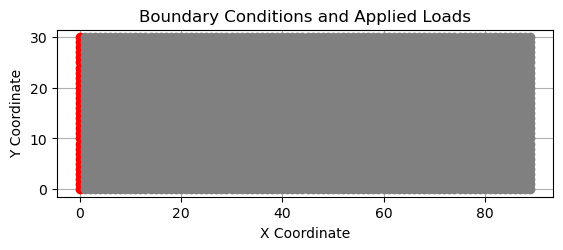

In [118]:
def plot_nodes(nelx, nely, dof_fixed, load_dof):
    
    loadplot = np.setdiff1d(load_dof, dof_fixed)
    
    print(loadplot)
    
    # load_i = load_dof // (2 * (nely + 1))
    # load_j = (load_dof // 2) % (nely + 1)
    fig, ax = plt.subplots()
    for i in range(nelx + 1):
        for j in range(nely + 1):
            # Calculate node index for the flat array structure
            node_index_x = 2 * (i * (nelx + 1) + j)     # DOF index for x-direction
            node_index_y = node_index_x + 1             # DOF index for y-direction

            if node_index_x in dof_fixed or node_index_y in dof_fixed:
                color = 'red'  # Fixed node
            elif node_index_y == load_dof:
                print("Green node at: ", i, j)
                color = 'green' # Applied load
            else:
                color = 'gray'  # Free node

            ax.plot(i, j, 'o', color=color)

    ax.set_aspect('equal', adjustable='box')
    plt.title('Boundary Conditions and Applied Loads')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

# print("load_dof index:", load_dof)
# print("Coordinates supposed to be green", load_i, load_j)

plot_nodes(nelx, nely, dof_fixed, load_dof,)

#### ANIMATION AND PLOT DISP

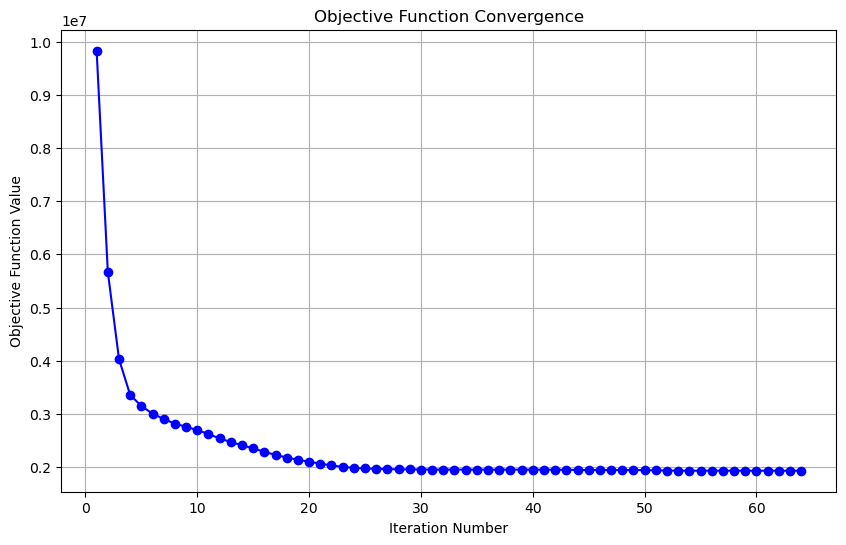

In [119]:
# Display convergence plot
convergencePlot(c_hist)

In [120]:
# Display animation inline
ani = make_animation(nelx, nely, x_hist)
HTML(ani.to_html5_video())

#### conclusions

#### REFERENCES
[1]Baumgartner, A., Harzheim, L.; Mattheck, C. 1992: SKO (Solf Kill Optim): The biological way to find an optimum structure topology. <i>Int. J. Fatigue</i> 14, 387-393<br>
[2]Beckers, M. 1999: Topology optimization using a dual method with descrete variables. <i>Struct. Optim.</i> 17, 14-24<br>
[3]Bendsoe, M.P. 1989: Optimal shape design as a material distribution problem. <i>Struct. Optim.</i> 1, 193-202<br>
[4]Bendsoe, M.P. 1995: <i>Optimization of structural topology, shape and material.</i> Berlin, Heidelberg, New York: Springer<br>
[5]Bendsoe, M.P.; Kikuchi, N. 1988: Generating optimal topologies in optimal design using a homogenization method. <i>Comp. Meth. Appl. Mech. Engrg.</i> 71, 197-224<br>
[6]Bendsoe, M.P.; Sigmund, O. 1999: Material interpolations in topology optimization. <i>Arch. Appl. Mech.</i> 69, 635-654<br>
[7]Sigmund, O. 1994: <i>Designof material structures using topology optimization.</i> PhD Thesis, Department of Solid Mechanics, Technical University of Denmark<br>
[8]Sigmund, O.; Petersson, J. 1998: Numerical instabilities in tpology optimization: a survey on procedures dealing with checkerboards, mesh-dependencies and local minima. <i>Struct. Optim.</i> 16, 68-75<br>
[9]Svanberg, K. 1987: The method of moving asymptotes - a new method for structural optimization.<i>Int. J. Numer. Meth. Engrg.</i> 24, 359-373<br>
[10]Zhou, M.; Rozvany, G.I.N. 1991: The COC algorithm, part II: Topological, geometry and generalized shape optimization. <i>Comp. Meth. Appl. Mech. Engrng.</i> 89, 197-224<br>

